<a href="https://colab.research.google.com/github/mobelaachir/Deep-Learning-/blob/main/MLOPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLOPs Portfolio


|Naam|studentnummer|Github|
|----|-------------|------|
|Henry Lau|22122958|HenryLau08|
|Mohamed Belaachir|22143572|Mobelaachir|
||||
||||

In [17]:
# %pip install kaggle
# %pip install ultralytics
# %pip install mlflow
# %pip install opencv-python

In [8]:
# Standaardbibliotheken
import os
import shutil
import zipfile
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

# Dataverwerking
import pandas as pd
import numpy as np
import yaml

# Visualisatie
import matplotlib.pyplot as plt
import seaborn as sns

# Afbeeldingen & Preprocessing
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Flatten, Dropout, BatchNormalization
)

# ========== Externe Tools & Tracking ==========
# from ultralytics import YOLO
from google.colab import drive
# import mlflow
# import kaggle

# Configuratie
# run it once
# shutil.move("kaggle.json", "/root/.config/kaggle/") # manually upload your kaggle.json file and run it once
# !chmod 600 /root/.config/kaggle/kaggle.json


In [9]:
drive.mount('/content/drive')

Mounted at /content/drive


Deze code maakt de juiste mappen aan die nodig zijn voor het project. Er wordt een map in Google Drive klaargezet om data op te slaan of te gebruiken. Ook wordt een speciale map gemaakt voor de instellingen van de Kaggle API, zodat data van Kaggle automatisch kan worden gedownload. Als de mappen al bestaan, geeft de code geen foutmelding.

In [10]:
base_dir = Path("/content/drive/MyDrive/Colab Notebooks/data")
base_dir.mkdir(parents=True, exist_ok=True)
os.makedirs("/root/.config/kaggle/", exist_ok=True)

# 1. INLEIDING

In dit project willen we een voertuigherkenningssysteem ontwikkelen dat werkt op edge-apparaten. Het systeem moet voertuigen herkennen en classificeren op basis van afbeeldingen, bijvoorbeeld als auto, bus, vrachtwagen of ander type voertuig. Het systeem bestaat uit twee onderdelen:

- **Edge Model:** Dit is een snel en lichtgewicht objectdetectiemodel dat voertuigen kan herkennen en uitsnijden uit de -aangeleverde afbeeldingen. Het model is geoptimaliseerd voor edge-apparaten, zodat het efficiënt functioneert op systemen met beperkte rekenkracht.

- **Cloud Model:** Dit is een geavanceerd deep learning-model dat het type voertuig bepaalt aan de hand van de uitsnedes die door het edge-apparaat zijn doorgestuurd.


# 2. Data Ingestion

Voor dit project is gebruikgemaakt van data afkomstig van Kaggle. De dataset bevat afbeeldingen van verschillende soorten voertuigen, zoals auto’s, bussen, vrachtwagens en motorfietsen. Deze data is gedownload met behulp van de Kaggle API en vervolgens opgeslagen in een gestructureerde mapindeling op Google Drive, zodat de afbeeldingen eenvoudig konden worden ingeladen voor verdere verwerking. Er zijn twee datasets gebruikt: één voor het edge-model en één voor het cloud-model.

- **Edge Model:** Het kleinere edge-model detecteert alleen voertuigen, zodat het snel en efficiënt kan draaien op edge-apparaten.

- **Cloud Model:** Het grotere model is verantwoordelijk voor het detecteren van voertuigen en het annoteren van de bijbehorende labels.



## 2.1 Kaggle Datasets

Er wordt een speciale map aangemaakt om de Kaggle-datasets op te slaan. Vervolgens wordt een voertuigdetectiedataset automatisch gedownload en uitgepakt in deze map, zodat de data direct klaarstaat voor gebruik in het project.

https://www.kaggle.com/datasets/sakshamjn/vehicle-detection-8-classes-object-detection

In [18]:
# kaggle_path = base_dir / 'kaggle'
# os.makedirs(kaggle_path, exist_ok=True)

# kaggle.api.dataset_download_files("sakshamjn/vehicle-detection-8-classes-object-detection", path=kaggle_path, unzip=True)

De code telt het aantal bestanden in de map met trainingsafbeeldingen binnen de Kaggle-dataset. Hiermee wordt bepaald hoeveel trainingsafbeeldingen beschikbaar zijn voor het model.

In [27]:
# kaggle_path = Path('/content/drive/MyDrive/Colab Notebooks/data/kaggle/')


In [25]:
print(len(os.listdir(os.path.join(kaggle_path, 'train/images'))))

8219


De trainset bevat 8.219 afbeeldingen van voertuigen die gebruikt worden voor het trainen van het model.

Er wordt een lijst gemaakt van alle afbeeldingen in de trainingsmap, waarbij alleen bestanden met '.jpg' worden meegenomen. Daarna wordt voor elke afbeelding de naam van het bijbehorende labelbestand gemaakt door de bestandsnaam te veranderen naar '.txt'. Zo horen de labels bij de juiste afbeeldingen.

In [28]:
images_path = kaggle_path / "train/images"
labels_path = kaggle_path / "train/labels"

images = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
labels = [f.replace('.jpg', '.txt') for f in images]

**uitleg

In [29]:
def extract_labels_and_bboxes(label_file):
    """
    Leest een labelbestand en geeft per regel een label en bbox-coördinaten terug als tuple.
    Args:
        label_file (str): Pad naar het labelbestand.
    Yields:
        tuple: Een tuple van (label, bbox) waar label een integer is en bbox een lijst van vier floats.
    """
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            yield int(parts[0]), [float(x) for x in parts[1:]]

In [30]:
def load_kaggle_dataset(images_path, labels_path):
    """
    Laadt de Kaggle dataset en retourneert een DataFrame met image paths, labels en bounding boxes.
    Args:
        images_path (str): Pad naar de map met afbeeldingen.
        labels_path (str): Pad naar de map met labelbestanden.
    Returns:
        pd.DataFrame
    """
    data = []
    images = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
    labels = [f.replace('.jpg', '.txt') for f in images]

    for img, lbl in tqdm(zip(images, labels), total=len(images)):
        label_file = os.path.join(labels_path, lbl)
        for label, bbox in extract_labels_and_bboxes(label_file):
            data.append({
                'image_path': os.path.join(images_path, img),
                'label_path': label_file,
                'label': label,
                'x_center': bbox[0],
                'y_center': bbox[1],
                'width': bbox[2],
                'height': bbox[3]
            })
    return pd.DataFrame(data)

Er wordt eerst gekeken of er al een CSV-bestand met de gegevens bestaat. Als dat bestand er nog niet is, wordt de dataset ingeladen en daarna opgeslagen als CSV. Als het bestand al bestaat, wordt de data direct uit het CSV-bestand geladen. Zo hoeft het inladen van de dataset niet steeds opnieuw te gebeuren.

In [31]:
csv_path = os.path.join(base_dir, 'kaggle_data.csv')
if not os.path.exists(csv_path):
    df_kaggle = load_kaggle_dataset(images_path, labels_path)
    df_kaggle.to_csv(csv_path, index=False)
else:
    df_kaggle = pd.read_csv(csv_path)

In [32]:
display(df_kaggle.head(5))

,image_path,label_path,label,x_center,y_center,width,height
0,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,3,0.509804,0.411765,0.107843,0.245098
1,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,2,0.210784,0.616422,0.127451,0.232843
2,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,0,0.503750,0.405000,0.097500,0.245000
3,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,1,0.190000,0.598750,0.120000,0.232500
4,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,2,0.621250,0.610000,0.057500,0.125000


- De afbeeldingen hebben verschillende afmetingen en zijn dus niet allemaal even groot.

In [33]:
def get_image_size(path):
    """
    Haalt de afmetingen van een afbeelding op.
    Args:
        path (str): Pad naar de afbeelding.
    Returns:
        tuple: Afmetingen van de afbeelding (breedte, hoogte) of None bij een fout.

    """
    try:
        with Image.open(path) as img:
            return img.size
    except Exception as e:
        print(f"Fout bij openen van {path}: {e}")
        return None

with ThreadPoolExecutor(max_workers=8) as executor:
    sizes = list(executor.map(get_image_size, set(df_kaggle['image_path'])))

# Remove None values and get unique sizes
image_sizes = sorted(set(s for s in sizes if s is not None))

print(image_sizes)

[(382, 382), (384, 384), (388, 388), (390, 390), (392, 392), (394, 394), (396, 396), (398, 398), (400, 400), (402, 402), (404, 404), (406, 406), (408, 408), (410, 410), (412, 412), (416, 416), (640, 480), (640, 640)]


De functie laat een paar afbeeldingen zien met alle bijbehorende vakjes rondom de voertuigen. Je kunt kiezen om alleen afbeeldingen met een bepaald voertuig te zien en de volgorde van de afbeeldingen willekeurig maken. Voor elke afbeelding worden de vakjes getekend en een label erbij gezet. Daarna worden de afbeeldingen getoond zonder extra lijnen of tekst.

In [40]:
def show_image_with_all_bboxes(df, class_names=None, filter_label=None, amount=6, shuffle=False):
    """
    Toont 6 afbeeldingen met bounding boxes in een raster van 2 rijen en 3 kolommen.
    Args:
        df (pd.DataFrame): DataFrame met kolommen 'image_path', 'label', 'x_center', 'y_center', 'width', 'height'.
        class_names (list): Lijst met klassenamen.
        filter_label (int, optional): Specifiek label om op te filteren.
        amount (int): Aantal afbeeldingen om te tonen.
        shuffle (bool): Willekeurig schudden van afbeeldingen.
    """

    if filter_label is not None:
        unique_images = df[df['label'] == filter_label]['image_path'].unique()
    else:
        unique_images = df['image_path'].unique()

    if shuffle:
        np.random.shuffle(unique_images)

    selected_images = unique_images[:amount]

    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
    axes = axes.flatten()

    for ax, image_path in zip(axes, selected_images):
        image_rows = df[df['image_path'] == image_path]

        image = cv2.imread(image_path)
        if image is None:
            print(f"Afbeelding niet gevonden: {image_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        for _, row in image_rows.iterrows():
            cls = int(row['label'])
            x_center, y_center = row['x_center'], row['y_center']
            width, height = row['width'], row['height']

            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)

            color = (0, 255, 0) if filter_label is not None and cls == filter_label else (255, 0, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            label_text = class_names[cls] if class_names else str(cls)
            cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        ax.imshow(image)
        ax.axis('off')
        ax.set_title(image_path.split("/")[-1], fontsize=10)

    # Eventuele lege plots verbergen als er minder dan 6 afbeeldingen zijn
    for ax in axes[len(selected_images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


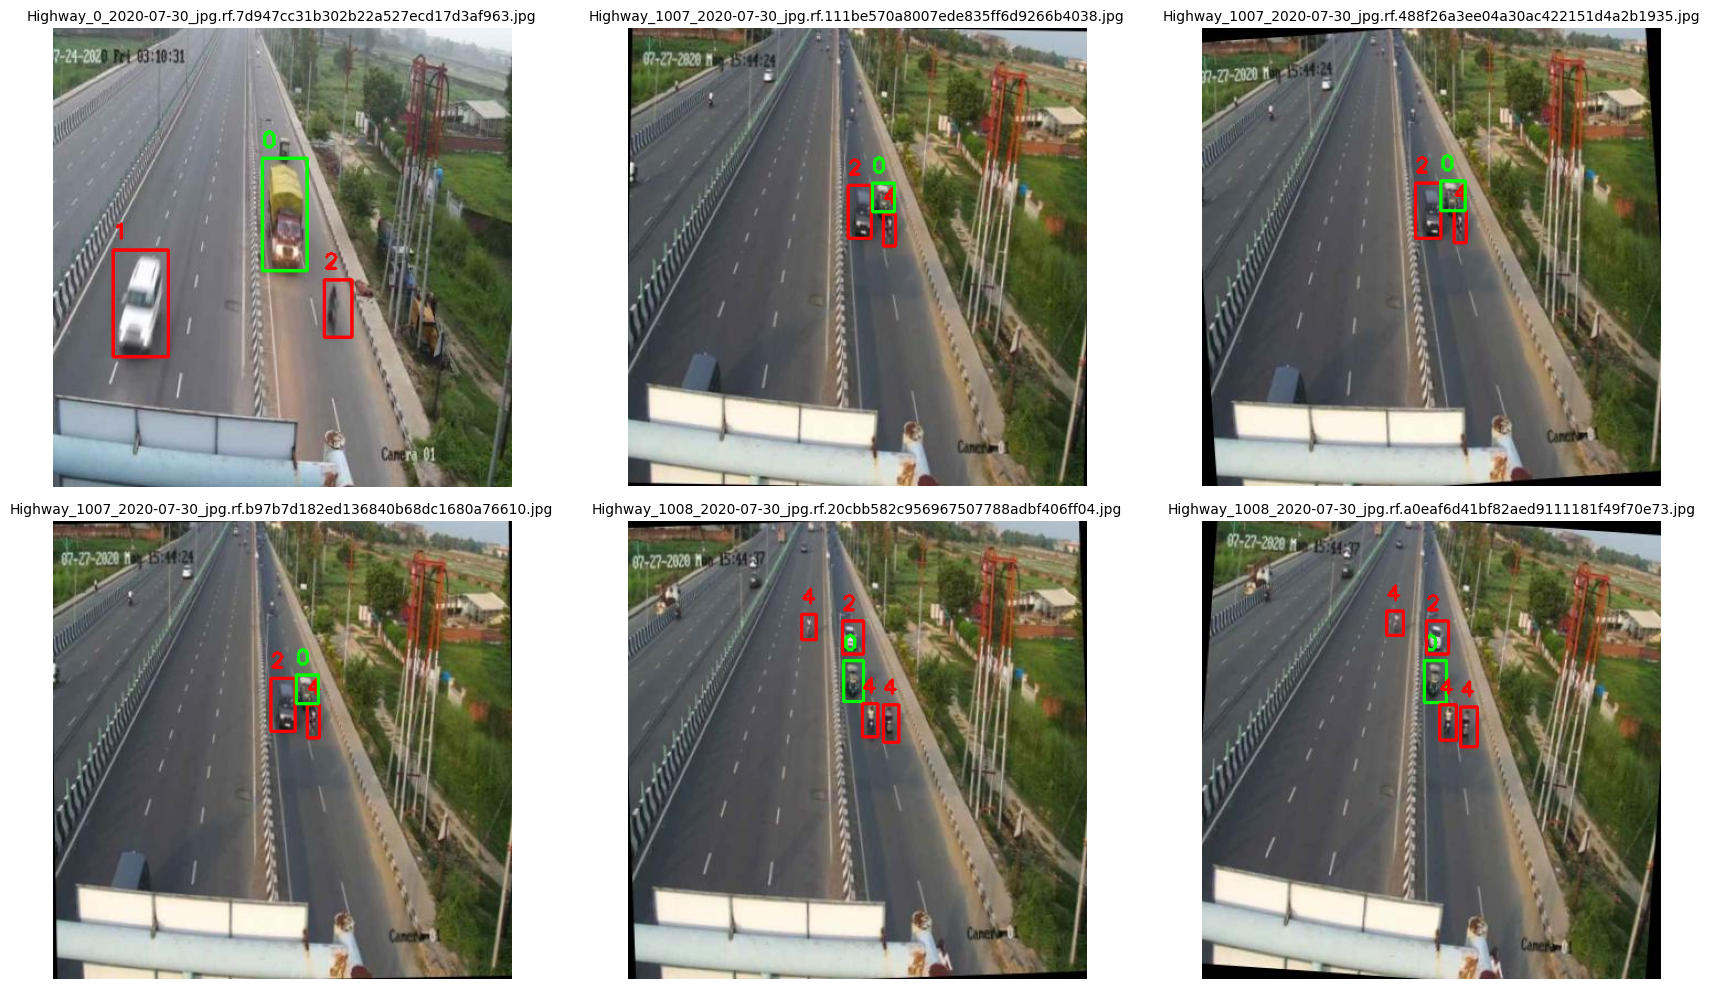

In [41]:
show_image_with_all_bboxes(df_kaggle, filter_label=0)

In [47]:
class_mapping = {
    0: 'Auto',
    1: 'Bus',
    2: 'Car',
    3: 'LCV',
    4: 'Motorcycle',
    5: 'Multi-Axle',
    6: 'Tractor',
    7: 'Truck'
}

df_classes = pd.DataFrame(list(class_mapping.items()), columns=['class_id', 'class_name'])
display(df_classes)


,class_id,class_name
0,0,Auto
1,1,Bus
2,2,Car
3,3,LCV
4,4,Motorcycle
5,5,Multi-Axle
6,6,Tractor
7,7,Truck


**klassen verdeling - data balans

In [45]:
# Tel het aantal voorbeelden per label
label_counts = df_kaggle['label'].value_counts().sort_index()
label_counts

,count
label,
0,819
1,1319
2,11425
3,969
4,7285
5,1147
6,171
7,2963


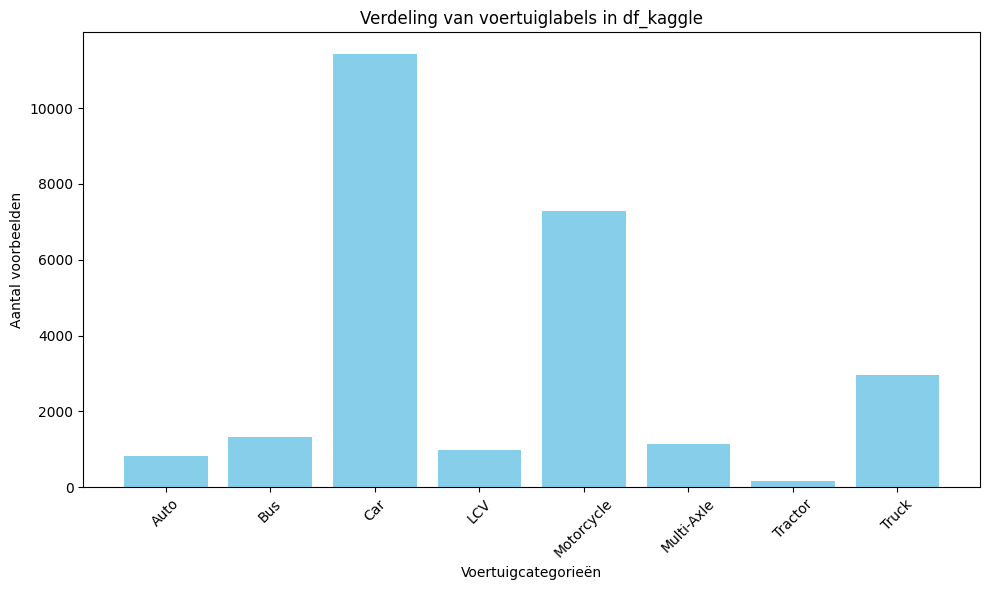

In [48]:
# Zet index om naar klassenamen
label_names = [class_mapping[i] for i in label_counts.index]

# Maak de staafgrafiek
plt.figure(figsize=(10, 6))
plt.bar(label_names, label_counts.values, color='skyblue')
plt.title('Verdeling van voertuiglabels in df_kaggle')
plt.xlabel('Voertuigcategorieën')
plt.ylabel('Aantal voorbeelden')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

De data in deze dataset is niet goed verdeeld over de verschillende voertuigcategorieën. Sommige klassen, zoals "Car" en "Motorcycle", komen zeer vaak voor, terwijl andere zoals "Tractor" en "Auto" nauwelijks voorkomen. Deze scheve verdeling, ook wel class imbalance genoemd, kan nadelig zijn voor het trainen van een betrouwbaar model, omdat het model vooral leert van de dominante categorieën en daardoor minder goed presteert op de minder voorkomende klassen.

# 3. Data Opschonen en Transformeren

Beschrijf de stappen voor data cleaning, data augmentation en data transformation.

In deze sectie beschrijf je de stappen voor het opschonen en transformeren van de data. Gebruik markdown-cellen om elke stap te beschrijven en code-cellen om de transformaties uit te voeren.

Data Cleaning

Beschrijf hoe je de afbeeldingen opschoont (bijvoorbeeld door ze allemaal naar hetzelfde formaat te converteren).

Voer kleurnormalisatie uit en pas cropping en padding toe waar nodig.

Data Augmentation

Beschrijf hoe je data augmentation toepast om de dataset te vergroten en het model robuuster te maken.

Gebruik technieken zoals rotatie, spiegeling, schalen, translatie, shearing en cropping.

Data Transformation

Beschrijf hoe je de afbeeldingen transformeert om ze geschikt te maken voor machine learning (bijvoorbeeld normalisatie en kleurtransformaties).

## 3.1 Data Cleaning

## 3.2 Data Augmentation

## 3.3 Data Transformation

# 4. Machine Learning Pipeline

Beschrijf hoe het objectdetectiemodel wordt getraind en geëvalueerd.


In deze sectie beschrijf je hoe je het objectdetectiemodel traint en evalueert. Gebruik markdown-cellen om elke stap te beschrijven en code-cellen om het model te trainen en te evalueren.

Objectdetectie Model

Beschrijf hoe je een objectdetectiemodel (bijvoorbeeld YOLO, Faster R-CNN of EfficientDet) traint op de dataset.

Leg uit hoe je het model evalueert met behulp van metrieken zoals precisie, recall en F1-score.

Image Captioning

Beschrijf eventueel hoe je een image captioning-model toevoegt om beschrijvingen van gedetecteerde voertuigen te genereren.



## 4.1 Train-Test Split

**uitleg

In [ ]:
data_dir = base_dir / 'working/dataset'

# 💡 Remove the entire dataset folder if it exists
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)

os.makedirs(os.path.join(data_dir, 'train/images'), exist_ok=True)
os.makedirs(os.path.join(data_dir, 'train/labels'), exist_ok=True)
os.makedirs(os.path.join(data_dir, 'test/images'), exist_ok=True)
os.makedirs(os.path.join(data_dir, 'test/labels'), exist_ok=True)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

for img, lbl in zip(train_images, train_labels):
    shutil.copy(os.path.join(images_path, img), os.path.join(data_dir, 'train/images', img))
    shutil.copy(os.path.join(labels_path, lbl), os.path.join(data_dir, 'train/labels', lbl))

for img, lbl in zip(test_images, test_labels):
    shutil.copy(os.path.join(images_path, img), os.path.join(data_dir, 'test/images', img))
    shutil.copy(os.path.join(labels_path, lbl), os.path.join(data_dir, 'test/labels', lbl))

## 4.2 Model Bouwen

**uitleg

In [ ]:
data_yaml = {
    'train': 'train/images',
    'val': 'test/images',
    'names': ['auto', 'bus', 'car', 'lcv', 'motorcycle', 'multiaxle', 'tractor', 'truck']
}

with open(f'{data_dir}/data.yaml', 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

## 4.3 Model Trainen

**uitleg

In [ ]:
# Laad een YOLOv8n model
model = YOLO('yolov8n.pt')  # Kies hier eventueel een ander model

# Definieer het pad naar je data.yaml bestand
data_yaml_path = data_dir / 'data.yaml'

# Train het model
results = model.train(data=data_yaml_path, epochs=10)  # Pas het aantal epochs aan indien nodig

Ultralytics 8.3.151  Python-3.12.7 torch-2.7.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=root\working\dataset\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

100%|██████████| 755k/755k [00:00<00:00, 19.6MB/s]

Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    752872  ultralytics.nn.modules.head.Detect           [8, [64, 128, 256]]           
Model summary: 129 layers, 3,012,408 parameters, 3,012,392 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access  (ping: 0.10.0 ms, read: 3.30.9 MB/s, size: 29.3 KB)


train: Scanning C:\Users\henry\Documents\GitHub\adsai-mlops-2025\root\working\dataset\train\labels... 6574 images, 14 backgrounds, 0 corrupt: 100%|██████████| 6574/6574 [00:28<00:00, 226.91it/s]

train: C:\Users\henry\Documents\GitHub\adsai-mlops-2025\root\working\dataset\train\images\highway_3297_2020-08-26.jpg: 1 duplicate labels removed


train: New cache created: C:\Users\henry\Documents\GitHub\adsai-mlops-2025\root\working\dataset\train\labels.cache
val: Fast image access  (ping: 0.10.0 ms, read: 4.13.7 MB/s, size: 68.3 KB)


c:\Users\henry\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\henry\Documents\GitHub\adsai-mlops-2025\root\working\dataset\test\labels... 1644 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1644/1644 [00:06<00:00, 238.00it/s]

val: C:\Users\henry\Documents\GitHub\adsai-mlops-2025\root\working\dataset\test\images\highway_2784_2020-08-26.jpg: 1 duplicate labels removed


val: New cache created: C:\Users\henry\Documents\GitHub\adsai-mlops-2025\root\working\dataset\test\labels.cache
Plotting labels to runs\detect\train3\labels.jpg... 


c:\Users\henry\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/06/07 16:03:21 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.
2025/06/07 16:03:21 WARNING mlflow.utils.autologging_utils: MLflow keras autologging is known to be compatible with 3.0.2 <= keras <= 3.9.2, but the installed version is 3.10.0. If you encounter errors during autologging, try upgrading / downgrading keras to a compatible version, or try upgrading MLflow.
2025/06/07 16:03:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/06/07 16:03:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/06/07 16:03:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/06/07 16:03:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(712ad728724d44949d9bb0bf82d9a18f) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\henry\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G      1.507      2.177       1.16         55        640: 100%|██████████| 411/411 [41:08<00:00,  6.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 30/52 [02:24<01:45,  4.81s/it]


KeyboardInterrupt: 

## 4.4 Model Evalueren


0: 640x640 2 cars, 2 motorcycles, 31.1ms
1: 640x640 4 cars, 31.1ms
Speed: 7.7ms preprocess, 31.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
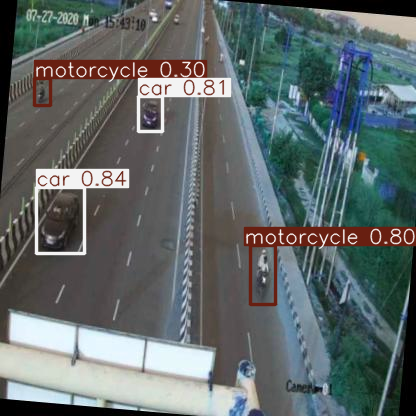

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
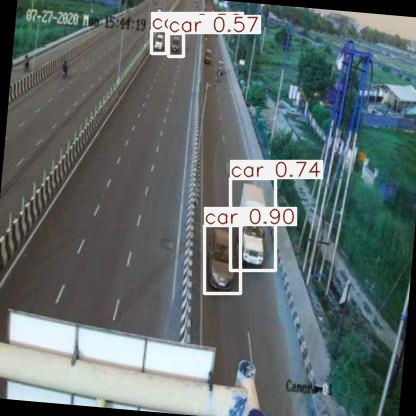

In [ ]:
# Laad het getrainde model (of gebruik het modelobject van de training)
model = YOLO('/content/runs/detect/train3/weights/best.pt') # Pas dit pad aan naar waar je model is opgeslagen

# Definieer de paden naar de afbeeldingen die je wilt gebruiken voor predictie
# Je kunt hier een lijst van afbeeldingspaden opgeven, bijvoorbeeld uit je testset
predict_images = [
    '/content/drive/MyDrive/Colab Notebooks/data/working/dataset/test/images/Highway_1000_2020-07-30_jpg.rf.e9364fb1c7d1bf9f8cbea3d1c1575050.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/working/dataset/test/images/Highway_1006_2020-07-30_jpg.rf.c58b7b2098d969e925b271bcd436ac25.jpg',
    # Voeg hier meer afbeeldingspaden toe
] # Pas deze paden aan

# Voer predicties uit
results = model.predict(predict_images)

# Toon de resultaten
for result in results:
    display(result.plot()) # result.plot() tekent de bounding boxes op de afbeelding

## Data 2 & Model 2

2e dataset  
**uitleg

https://www.kaggle.com/datasets/mmohaiminulislam/vehicles-image-dataset

In [ ]:
kaggle_path2 = Path('kaggle2')
os.makedirs(kaggle_path2, exist_ok=True)

kaggle.api.dataset_download_files("mmohaiminulislam/vehicles-image-dataset", path=kaggle_path2, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/mmohaiminulislam/vehicles-image-dataset


**uitleg

In [ ]:
len(os.listdir(kaggle_path2 / 'vehicle_data/airplane'))

173

**uitleg

In [ ]:
data_path = kaggle_path2/os.listdir(kaggle_path2)[0]
os.listdir(data_path)

['airplane',
 'ambulance',
 'bicycle',
 'boat',
 'bus',
 'car',
 'fire_truck',
 'helicopter',
 'hovercraft',
 'jet_ski',
 'kayak',
 'motorcycle',
 'rickshaw',
 'scooter',
 'segway',
 'skateboard',
 'tractor',
 'truck',
 'unicycle',
 'van']

**uitleg

In [ ]:
# Create a list to store file paths and folder names
image_data = []

# Loop through each folder and file
for folder in data_path.iterdir():
    if folder.is_dir():  # Only look inside directories
        for file in folder.iterdir():
            if file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:  # image extensions
                image_data.append({
                    'image_path': str(file),
                    'vehicle_type': folder.name
                })

# Create the DataFrame
df = pd.DataFrame(image_data)

# Show the result
print(df.head())

                                          image_path vehicle_type
0  kaggle2\vehicle_data\airplane\001193bb-8afd-47...     airplane
1  kaggle2\vehicle_data\airplane\01e9793f-3e09-4f...     airplane
2  kaggle2\vehicle_data\airplane\03e50e91-b7eb-4c...     airplane
3  kaggle2\vehicle_data\airplane\04e0cc76-81a6-49...     airplane
4  kaggle2\vehicle_data\airplane\04f16503-f5d5-45...     airplane


**uitleg

In [ ]:
df['vehicle_type'].value_counts()

vehicle_type
tractor       194
scooter       194
motorcycle    191
boat          191
kayak         190
skateboard    188
van           188
jet_ski       187
segway        187
car           185
helicopter    184
hovercraft    184
fire_truck    184
bus           184
rickshaw      183
ambulance     181
bicycle       178
unicycle      177
airplane      173
truck         169
Name: count, dtype: int64

**uitleg

In [ ]:
img_size = (128, 128)  # you can change this size as needed

# Load and preprocess images
X = []
for path in df['image_path']:
    img = Image.open(path)
    if img.mode == 'P':
        img = img.convert('RGBA').convert('RGB') # png images with P mode has 4 channels, then convert to 3 channels
    else:
        img = img.convert('RGB')                # Convert to 3 channels
    img = img.resize(img_size)                  # Resize
    img_array = img_to_array(img) / 255.0       # Convert to array and normalize
    X.append(img_array)

X = np.array(X)

# Encode labels
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(df['vehicle_type'])
y = to_categorical(y_int)  # One-hot encode for CNN classification

# X shape: (num_samples, height, width, channels)
# y shape: (num_samples, num_classes)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Classes: {label_encoder.classes_}")


X shape: (3692, 128, 128, 3)
y shape: (3692, 20)
Classes: ['airplane' 'ambulance' 'bicycle' 'boat' 'bus' 'car' 'fire_truck' 'helicopter' 'hovercraft' 'jet_ski' 'kayak' 'motorcycle' 'rickshaw' 'scooter' 'segway' 'skateboard' 'tractor' 'truck' 'unicycle' 'van']


**uitleg

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_int)

In [ ]:
# Define augmentation
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use only basic preprocessing (no augmentation) for validation
valgen = ImageDataGenerator()

# Create generators
train_gen = datagen.flow(X_train, y_train, batch_size=32)
val_gen = valgen.flow(X_val, y_val, batch_size=32)

**uitleg

In [ ]:
# Model parameters
input_shape = X_train.shape[1:]
num_classes = y.shape[1]

# model2 = Sequential([
#     Input(shape=input_shape),
#     Conv2D(32, (3, 3), activation='relu'),
#     MaxPooling2D(),

#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(),

#     Conv2D(128, (3, 3), activation='relu'),
#     GlobalAveragePooling2D(),

#     Dense(64, activation='relu'),
#     Dense(num_classes, activation='softmax')
# ])

model2 = Sequential([
    Input(shape=input_shape),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Show summary
model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,236 (442.33 KB)

 Trainable params: 112,788 (440.58 KB)

 Non-trainable params: 448 (1.75 KB)

**uitleg

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',        # Watch the validation loss
    patience=10,               # Stop after 10 epochs with no improvement
    restore_best_weights=True # Roll back to the best weights found
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Watch the validation loss
    factor=0.5,            # Reduce LR by half
    patience=5,            # Wait 5 epochs before reducing LR
    min_lr=1e-6            # Don’t let LR go below this
)


In [ ]:
# Train with generators
history2 = model2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stop, reduce_lr]
)

2025/06/07 19:46:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\henry\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored."


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 46s 473ms/step - accuracy: 0.0586 - loss: 3.2212 - val_accuracy: 0.0595 - val_loss: 3.0088 - learning_rate: 1.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 461ms/step - accuracy: 0.1139 - loss: 2.8815 - val_accuracy: 0.0514 - val_loss: 3.0385 - learning_rate: 1.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 472ms/step - accuracy: 0.1358 - loss: 2.7861 - val_accuracy: 0.0514 - val_loss: 3.0435 - learning_rate: 1.0000e-04
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 464ms/step - accuracy: 0.1471 - loss: 2.7393 - val_accuracy: 0.0839 - val_loss: 2.9537 - learning_rate: 1.0000e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 47s 504ms/step - accuracy: 0.1665 - loss: 2.6710 - val_accuracy: 0.1353 - val_loss: 2.8235 - learning_rate: 1.0000e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 45s 484ms/step - accuracy: 0.1861 - loss: 2.6608 - val_accuracy: 0.1678 - val_loss: 2.6748 - learning_rate: 1.0000e-04
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 473ms/ste

2025/06/07 20:53:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'runs\mlflow' does not exist.


**uitleg

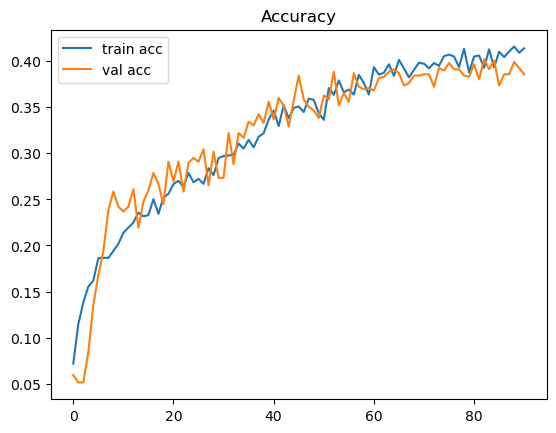

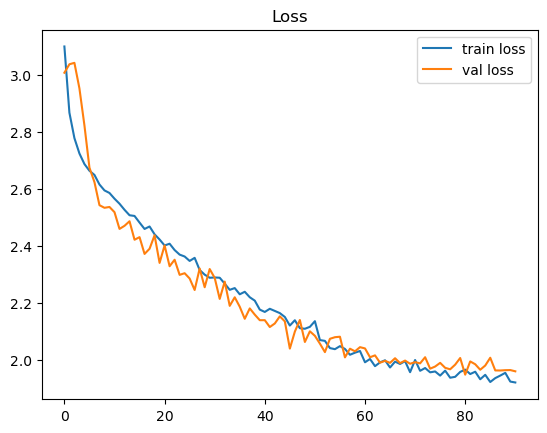

In [ ]:
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
mlflow.set_experiment("vehicle-type-cnn")

with mlflow.start_run():
    # Log parameters
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("learning_rate", 0.0001)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("dropout", 0.25)
    mlflow.log_param("regularization", 0.001)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model2.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train and log metrics automatically
    history = model2.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=20,
                        callbacks=[early_stop, reduce_lr])

    # Log final metrics
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    mlflow.log_metric("val_accuracy", val_acc)
    mlflow.log_metric("val_loss", val_loss)

    # Log the model
    mlflow.tensorflow.log_model(model, artifact_path="model")


# 5. Deployment

Beschrijf hoe het model wordt gedeployed op edge-apparaten en in de cloud.

In deze sectie beschrijf je hoe je het model deployt op edge-apparaten en in de cloud. Gebruik markdown-cellen om de deploymentstrategie te beschrijven.

Edge Deployment

Beschrijf hoe je het model implementeert op edge-apparaten zoals slimme camera's of embedded systemen.

Leg uit hoe je ervoor zorgt dat het model realtime voertuigdetectie kan uitvoeren.

Cloud Deployment

Beschrijf hoe je het geavanceerde deep learning-model in de cloud deployt voor voertuigclassificatie.



## 5.1 Edge Deployment

## 5.2 Cloud Deployment

# 6. Monitoring en Feedback

Beschrijf hoe de prestaties van het model worden gemonitord en hoe het model wordt hertraind op basis van nieuwe data.

In deze sectie beschrijf je hoe je de prestaties van het model monitort en hoe je het model hertraind op basis van nieuwe data. Gebruik markdown-cellen om de monitoringstrategie te beschrijven.

Data Drift Detection

Beschrijf hoe je veranderingen in de inkomende data detecteert en hoe je hierop reageert.

Model Performance Monitoring

Beschrijf hoe je de nauwkeurigheid, recall en precision van het model continu monitort.

Leg uit hoe je automatisch logging van verkeerde voorspellingen implementeert.

Hertraining

Beschrijf hoe je het model periodiek hertraind op basis van nieuwe data en feedback.

7. Conclusie


## 6.1 Data Drift Detection

## 6.2 Hertraining

# 7. Conclusie

Geef een samenvatting van de datapijplijn en bespreek eventuele uitdagingen of verbeterpunten.

In deze sectie geef je een samenvatting van de datapijplijn en bespreek je eventuele uitdagingen of verbeterpunten. Gebruik markdown-cellen om de conclusie te schrijven.




# 8. Bronvermelding